# Ford Go Bike 2018
|   * * * * * * * * * *   | **Udacity**         | 
| -------------           |:-------------:      |
| **Nanodegree:**         | *Data Analyst*    | 
| **Student:**            | *Theresa Kocher*    |
| **Date:**               | *4th May 2019*|


## Investigation Overview

> In this investigation, I wanted to look at the different city where the bike rent service is available and if there are differences .

## Dataset Overview

> The data considers the rent activity data of the bike rental agency of Ford. To avoid long computation times only the acquired data of the year 2018 are analysed.

In [1]:
import glob, os
import numpy as np
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as dates
from IPython.core.display import Image, display
from mpl_toolkits.basemap import Basemap
from PIL import Image
import pylab as pl

%matplotlib inline

In [2]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(12,6)})
sns.set(font_scale=1.2)
sns.set_palette("pastel")
base_color = sns.color_palette()[0]

### Load data

#### Rent activity dataframe

In [3]:
conn = sqlite3.connect("data/cleaned/rent.db")
rent_clean = pd.read_sql_query("select * from rent;", conn)
rent_clean.head()

,rent_id,bike_id,bike_share_for_all_trip,duration_sec,start_station_id,start_time,end_station_id,end_time,year,month,hour
0,0,1035,0,598,284,2018-02-28 23:59:47.097000,114,2018-03-01 00:09:45.187000,2018,2,23
1,1,1673,0,943,6,2018-02-28 23:21:16.495000,324,2018-02-28 23:36:59.974000,2018,2,23
2,2,3498,0,18587,93,2018-02-28 18:20:55.190000,15,2018-02-28 23:30:42.925000,2018,2,18
3,3,3129,0,18558,93,2018-02-28 18:20:53.621000,15,2018-02-28 23:30:12.450000,2018,2,18
4,4,1839,1,885,308,2018-02-28 23:15:12.858000,297,2018-02-28 23:29:58.608000,2018,2,23


#### User information (per rent activity)

In [4]:
conn = sqlite3.connect("data/cleaned/member.db")
member_clean = pd.read_sql_query("select * from member;", conn)
member_clean.head()

,rent_id,member_gender,member_birth_year,user_type,age
0,0,Male,1988.0,Subscriber,30.0
1,1,Male,1987.0,Customer,31.0
2,2,Female,1986.0,Customer,32.0
3,3,Male,1981.0,Customer,37.0
4,4,Female,1976.0,Subscriber,42.0


#### Rent Station dataframe

In [67]:
conn = sqlite3.connect("data/cleaned/station.db")
station_clean = pd.read_sql_query("select * from station;", conn)
station_clean.head()

,id,latitude,longitude,name
0,284.0,37.784872,-122.400876,Yerba Buena Center for the Arts (Howard St at ...
1,6.0,37.804770,-122.403234,The Embarcadero at Sansome St
2,93.0,37.770407,-122.391198,4th St at Mission Bay Blvd S
3,308.0,37.336802,-121.894090,San Pedro Square
4,312.0,37.329732,-121.901782,San Jose Diridon Station


In [8]:
# type conversions that got lost with ex- and import
rent_clean['bike_share_for_all_trip'] = rent_clean['bike_share_for_all_trip'].astype(bool)
rent_clean['end_time'] = pd.to_datetime(rent_clean['end_time'])
rent_clean['start_time'] = pd.to_datetime(rent_clean['start_time'])
rent_clean['start_station_id'] = rent_clean['start_station_id'].astype(int)
rent_clean['end_station_id'] = rent_clean['end_station_id'].astype(int)

## 4. Analyze and Visualize

### Univariate Explorations

In [9]:
# preparing data for amount of rents over time
amount_of_rent = rent_clean[['start_time']].copy()
amount_of_rent['amount'] = 1
amount_of_rent['date'] = rent_clean['start_time'].dt.date

rent_timeseries = pd.DataFrame(amount_of_rent.groupby('date')['amount'].sum())

In [10]:
# new feature 'amount' into station_clean
amount_of_rent = rent_clean[['start_time']].copy()
amount_of_rent['amount'] = 1
amount_of_rent['hour'] = rent_clean['start_time'].dt.hour
amount_of_rent['month'] = rent_clean['start_time'].dt.month

#print(hourly_amount['amount'].min(), hourly_amount['amount'].max())

### 4.3 Business and Location of the rent stations

Where are those rent stations located? And how busy are those rent stations? Where are the busiest rent stations?

Preparing: Feature development

- add new feature 'amount' to station dataframe (the amount of rents in that station in year 2018).

In [11]:
# preparing rush on stations
rush_df = rent_clean.copy()
rush_df['amount'] = 1

station_rush_start = pd.DataFrame(rush_df.groupby('start_station_id')['amount'].sum())
station_rush_end = pd.DataFrame(rush_df.groupby('end_station_id')['amount'].sum())
print('amount start stations: ', station_rush_start.shape[0])
print('amount end stations: ', station_rush_end.shape[0])

station_rush_end.index.names = ['start_station_id']

rush = station_rush_start # .append(pd.DataFrame(station_rush_end))

print('BEFORE merging start and end ids: ', rush.shape)

for i, row in pd.DataFrame(station_rush_end).iterrows():
    if i in list(rush.index):
        rush.loc[i, 'amount'] += row['amount']
    else:
        rush = rush.append(row)
        
print('AFTER merging start and end ids: ', rush.shape)

amount start stations:  331
amount end stations:  331
BEFORE merging start and end ids:  (331, 1)
AFTER merging start and end ids:  (331, 1)


Before and after merging start and end stations, there are still 331 stations. This means, all stations are used as start and end stations.

In [12]:
# copy the amount of stations (in rush df) to a full station data frame
rush_stations = station_clean.copy()
rush_stations['amount'] = 0

for i, row in rush_stations.iterrows():
    station_id = row['id']
    if station_id in list(rush.index.values):
        amount = rush['amount'][station_id]
        rush_stations.loc[i, 'amount'] = amount

In [13]:
# converting data type to int
rush_stations['id'] = rush_stations['id'].astype(int)

Stations dataframe with new feature `amount`

In [14]:
rush_stations.head()

,id,latitude,longitude,name,amount
0,284,37.784872,-122.400876,Yerba Buena Center for the Arts (Howard St at ...,22990
1,6,37.804770,-122.403234,The Embarcadero at Sansome St,72612
2,93,37.770407,-122.391198,4th St at Mission Bay Blvd S,37363
3,308,37.336802,-121.894090,San Pedro Square,6053
4,312,37.329732,-121.901782,San Jose Diridon Station,11588


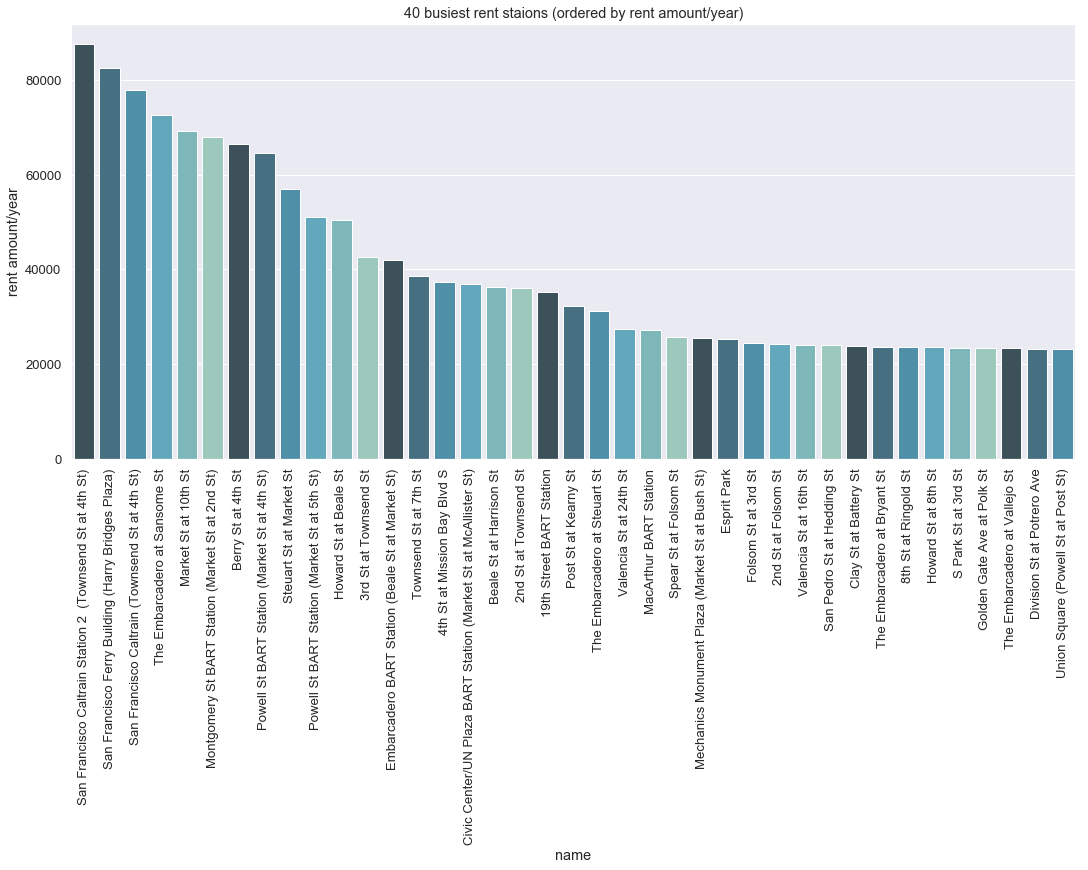

In [16]:
#preparing data
result = rush_stations.groupby(["name"])['amount'].aggregate(np.median).reset_index().sort_values('amount')

# show only left 40 bussyiest stations
fig, ax = fig, ax = plt.subplots()
fig.set_size_inches(18, 8)
ax = sns.barplot(x='name', y="amount", data=rush_stations, order=result['name'].iloc[:308:-1], palette=sns.color_palette("GnBu_d"))
ax.set_ylabel('rent amount/year')
plt.title('40 busiest rent staions (ordered by rent amount/year)')
plt.xticks(rotation=90);

In the above visualization, we can see that the station with name `San FranciscoCaltrain Station 2 (Townsened St at 4th St)` is the station with the most rents in year 2018. There are about 10-20 more busier stations with decreasing amount of rents. All other stations are less busy and had more or less the same amount of rents in the year 2018 (about 20000 rents/year).

#### Location of stations (and their amount of rents/year)

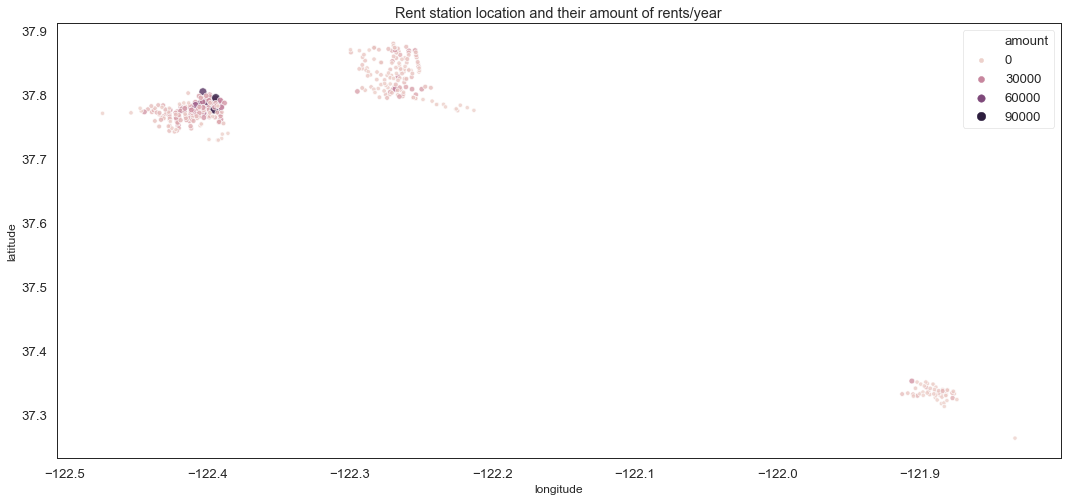

In [24]:
sns.set_style("white")

fig, ax = fig, ax = plt.subplots()
fig.set_size_inches(18, 8)
ax = sns.scatterplot(x="longitude", y="latitude",
                      hue="amount", size="amount",alpha=.8,
                      data=rush_stations);
#ax.set_ylim(rush_stations['latitude'].min(), rush_stations['latitude'].max())
ax.set_title("Rent station location and their amount of rents/year");

In [25]:
sns.set_style("whitegrid")
sns.set_palette("pastel")
base_color = sns.color_palette()[0]

#### Rent stations in map

See example from: https://jakevdp.github.io/PythonDataScienceHandbook/04.13-geographic-data-with-basemap.html

In [26]:
# Extract the data we're interested in
lat = rush_stations['latitude'].values
lon = rush_stations['longitude'].values
amount = rush_stations['amount'].values
#area = cities['area_total_km2'].values


In [27]:
print('latitude range:', rush_stations['latitude'].min(), rush_stations['latitude'].max())
print('longitude range: ',rush_stations['longitude'].min(), rush_stations['longitude'].max())

print('latitude mean:', rush_stations['latitude'].mean())
print('longitude mean: ',rush_stations['longitude'].mean())


mean_latitude = rush_stations['latitude'].mean()
mean_longitude = rush_stations['longitude'].mean()
diff_latitude = rush_stations['latitude'].max() - rush_stations['latitude'].min()
diff_longitude =  rush_stations['longitude'].max() - rush_stations['longitude'].min()

print(mean_latitude, mean_longitude)
print(diff_latitude, diff_longitude)

latitude range: 37.26331 37.88022244590679
longitude range:  -122.473658 -121.83333200000001
latitude mean: 37.73065393097607
longitude mean:  -122.27529277694882
37.73065393097607 -122.27529277694882
0.6169124459067916 0.6403259999999875


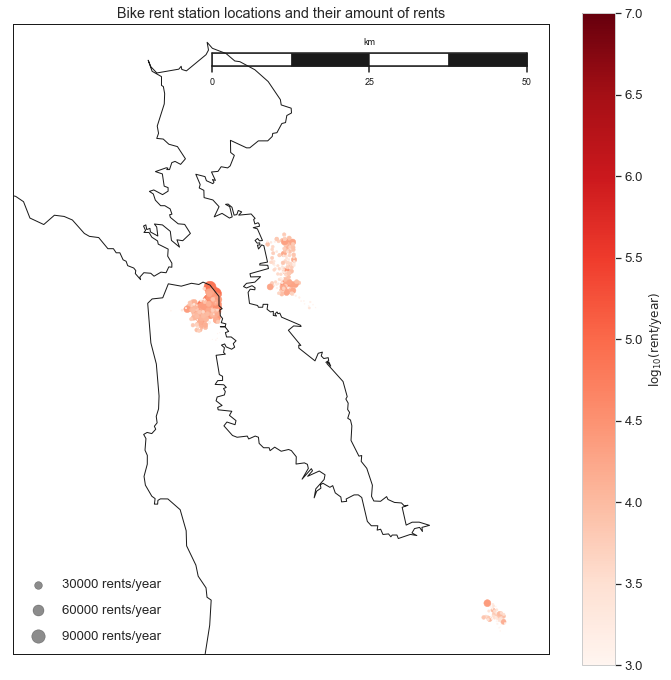

In [28]:
# 1. Draw the map background
fig = plt.figure(figsize=(12, 12))
m = Basemap(projection='tmerc', resolution='h', 
            lat_0=mean_latitude, lon_0=mean_longitude,
            width=0.085E6, height=0.1E6)
#m.shadedrelief()
m.drawcoastlines()
m.drawcountries(color='gray')
#m.fillcontinents(color="#cc9955", lake_color="aqua")
m.drawmapboundary()
#m.drawrivers()
#m.drawstates(color='gray')

m.drawmapscale(lon=mean_longitude+0.16, lat=mean_latitude+0.4, lon0=mean_longitude, lat0=mean_latitude, length=50, barstyle='fancy')

# 2. scatter city data, with color reflecting population
# and size reflecting area
m.scatter(lon, lat, latlon=True,
          c=np.log10(amount), s=amount/500,
          cmap='Reds', alpha=1)
#plt.scatter(lon, lat, 10, marker='o', color='red')

#x, y = m(lon, lat) # transform coordinates
#plt.scatter(x,y,10, marker='o', color='red')


plt.title('Bike rent station locations and their amount of rents');
#plt.show()

# 3. create colorbar and legend
plt.colorbar(label=r'$\log_{10}({\rm rent/year})$')
plt.clim(3, 7)

# make legend with dummy points
for a in [30000, 60000, 90000]:
    plt.scatter([], [], c='k', alpha=0.5, s=a/500,
                label=str(a) + ' rents/year')
plt.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left');

When we plot the station locations into a map, we see that there are three main parts (clusters), where the stations are located. It seems that the rent service has stations in three different cities. Let's try to find out, where the center of those 3 station clusters are. So that we can name them by their city name in an additional feature.

### 4.3 Cluster the 3 regions of rent stations

Use k-means algorithm from:  https://mubaris.com/posts/kmeans-clustering/

In [30]:
%matplotlib inline
from copy import deepcopy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')


In [ ]:
# Getting the values and plotting it
f1 = rush_stations['latitude'].values
f2 = rush_stations['longitude'].values
X = np.array(list(zip(f1, f2)))
plt.scatter(f2, f1, c='black', s=7);
plt.title("Rent station's location")
plt.xlabel('longitude')
plt.ylabel('latitude')

In [32]:
# Euclidean Distance Caculator
def dist(a, b, ax=1):
    return np.linalg.norm(a - b, axis=ax)


In [33]:
# Number of clusters
k = 3
# X coordinates of random centroids
C_x = np.array([37.4, 37.7, 37.9])
# Y coordinates of random centroids
C_y = np.array([-122.0, -122.4, -122.2])
C = np.array(list(zip(C_x, C_y)), dtype=np.float32)
print(C)


[[  37.4 -122. ]
 [  37.7 -122.4]
 [  37.9 -122.2]]


Text(0, 0.5, 'latitude')

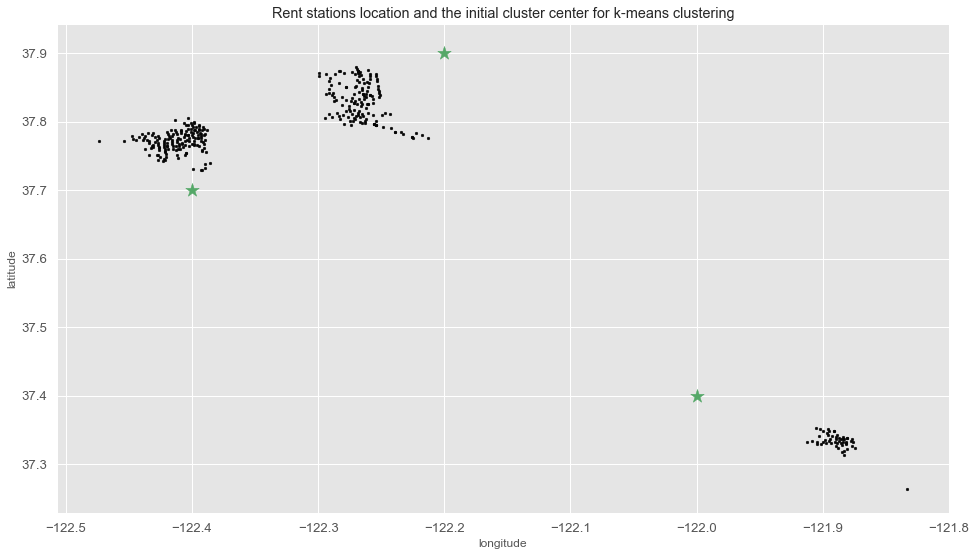

In [35]:
# Plotting along with the Centroids
plt.scatter(f2, f1, c='#050505', s=7)
plt.scatter(C_y, C_x, marker='*', s=200, c='g')
plt.title('Rent stations location and the initial cluster center for k-means clustering')
plt.xlabel('longitude')
plt.ylabel('latitude')

In [36]:
# To store the value of centroids when it updates
C_old = np.zeros(C.shape)
# Cluster Lables(0, 1, 2)
clusters = np.zeros(len(X))
# Error func. - Distance between new centroids and old centroids
error = dist(C, C_old, None)
# Loop will run till the error becomes zero
while error != 0:
    # Assigning each value to its closest cluster
    for i in range(len(X)):
        distances = dist(X[i], C)
        cluster = np.argmin(distances)
        clusters[i] = cluster
    # Storing the old centroid values
    C_old = deepcopy(C)
    # Finding the new centroids by taking the average value
    for i in range(k):
        points = [X[j] for j in range(len(X)) if clusters[j] == i]
        C[i] = np.mean(points, axis=0)
    error = dist(C, C_old, None)



Text(0, 0.5, 'latitude')

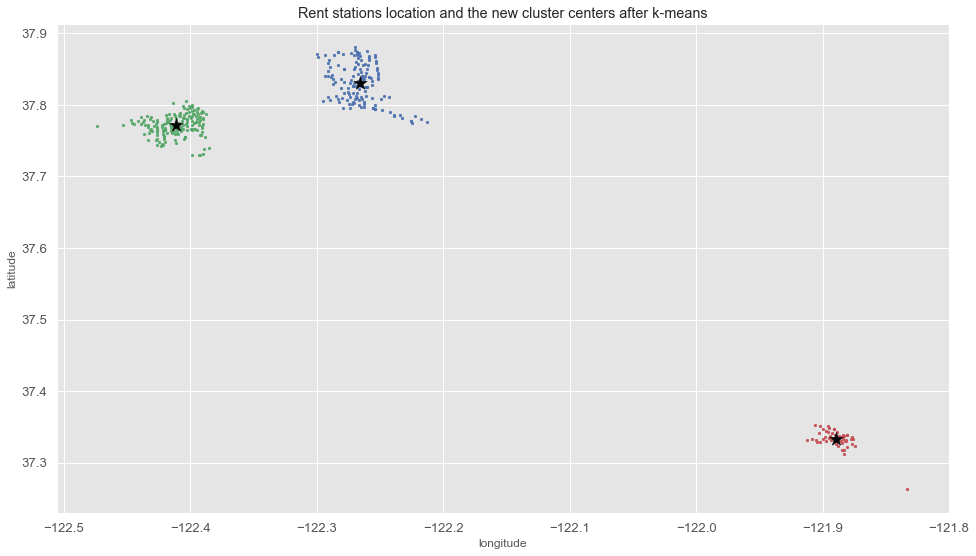

In [37]:
colors = ['r', 'g', 'b', 'y', 'c', 'm']
fig, ax = plt.subplots()
for i in range(k):
        points = np.array([X[j] for j in range(len(X)) if clusters[j] == i])
        ax.scatter(points[:, 1], points[:, 0], s=7, c=colors[i])
ax.scatter(C[:, 1], C[:, 0], marker='*', s=200, c='#050505');
plt.title('Rent stations location and the new cluster centers after k-means')
plt.xlabel('longitude')
plt.ylabel('latitude')

In [38]:
C

array([[  37.333435, -121.88909 ],
       [  37.771667, -122.411606],
       [  37.830585, -122.26604 ]], dtype=float32)

There were three city centers found: **San_Jose**, **San_Francisco**, **East_Bay**.

#### Bike rent stations in San José

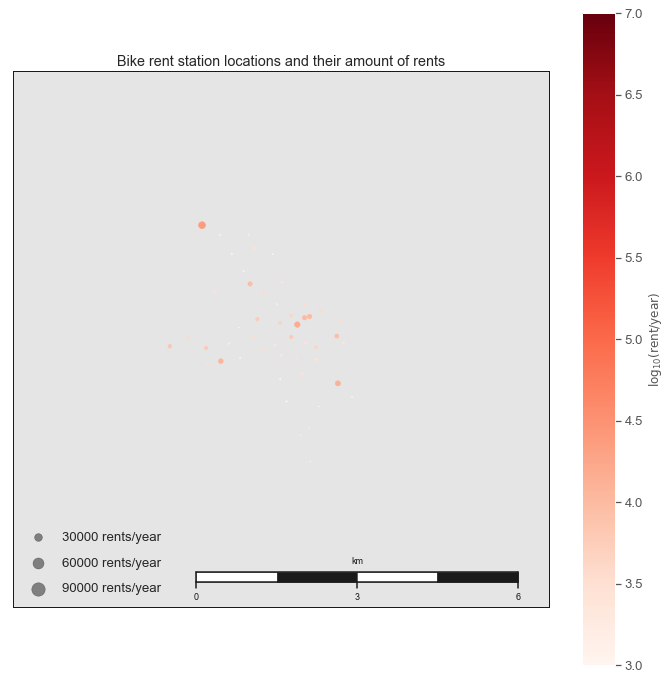

In [39]:
# draw map for first cluster center
center = C[0]

# 1. Draw the map background
fig = plt.figure(figsize=(12, 12))
m = Basemap(projection='tmerc', resolution='h', 
            lat_0=center[0], lon_0=center[1],
            width=0.01E6, height=0.01E6)
#m.shadedrelief()
m.drawcoastlines()
m.drawcountries(color='gray')
#m.fillcontinents(color="#cc9955", lake_color="aqua")
m.drawmapboundary()
#m.drawrivers()
#m.drawstates(color='gray')

m.drawmapscale(lon=center[1]+0.016, lat=center[0]-0.04, 
               lon0=center[1], lat0=center[0], length=6, barstyle='fancy')

# 2. scatter city data, with color reflecting population
# and size reflecting area
m.scatter(lon, lat, latlon=True,
          c=np.log10(amount), s=amount/500,
          cmap='Reds', alpha=1)
#plt.scatter(lon, lat, 10, marker='o', color='red')

#x, y = m(lon, lat) # transform coordinates
#plt.scatter(x,y,10, marker='o', color='red')


plt.title('Bike rent station locations and their amount of rents');
#plt.show()

# 3. create colorbar and legend
plt.colorbar(label=r'$\log_{10}({\rm rent/year})$')
plt.clim(3, 7)

# make legend with dummy points
for a in [30000, 60000, 90000]:
    plt.scatter([], [], c='k', alpha=0.5, s=a/500,
                label=str(a) + ' rents/year')
plt.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left');

#### Bike rent stations in San Francisco

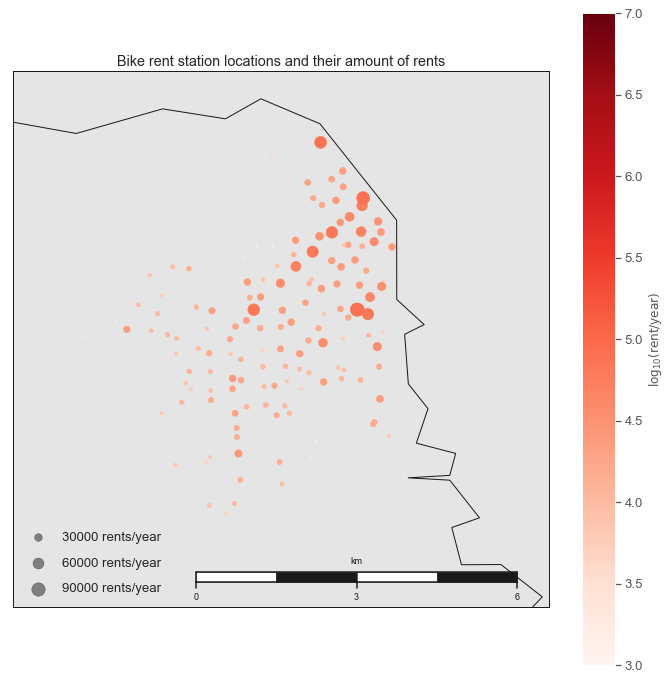

In [40]:
# draw map for first cluster center
center = C[1]

# 1. Draw the map background
fig = plt.figure(figsize=(12, 12))
m = Basemap(projection='tmerc', resolution='h', 
            lat_0=center[0], lon_0=center[1],
            width=0.01E6, height=0.01E6)
#m.shadedrelief()
m.drawcoastlines()
m.drawcountries(color='gray')
#m.fillcontinents(color="#cc9955", lake_color="aqua")
m.drawmapboundary()
#m.drawrivers()
#m.drawstates(color='gray')

m.drawmapscale(lon=center[1]+0.016, lat=center[0]-0.04, 
               lon0=center[1], lat0=center[0], length=6, barstyle='fancy')

# 2. scatter city data, with color reflecting population
# and size reflecting area
m.scatter(lon, lat, latlon=True,
          c=np.log10(amount), s=amount/500,
          cmap='Reds', alpha=1)
#plt.scatter(lon, lat, 10, marker='o', color='red')

#x, y = m(lon, lat) # transform coordinates
#plt.scatter(x,y,10, marker='o', color='red')


plt.title('Bike rent station locations and their amount of rents');
#plt.show()

# 3. create colorbar and legend
plt.colorbar(label=r'$\log_{10}({\rm rent/year})$')
plt.clim(3, 7)

# make legend with dummy points
for a in [30000, 60000, 90000]:
    plt.scatter([], [], c='k', alpha=0.5, s=a/500,
                label=str(a) + ' rents/year')
plt.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left');

#### Bike rent stations in East Bay

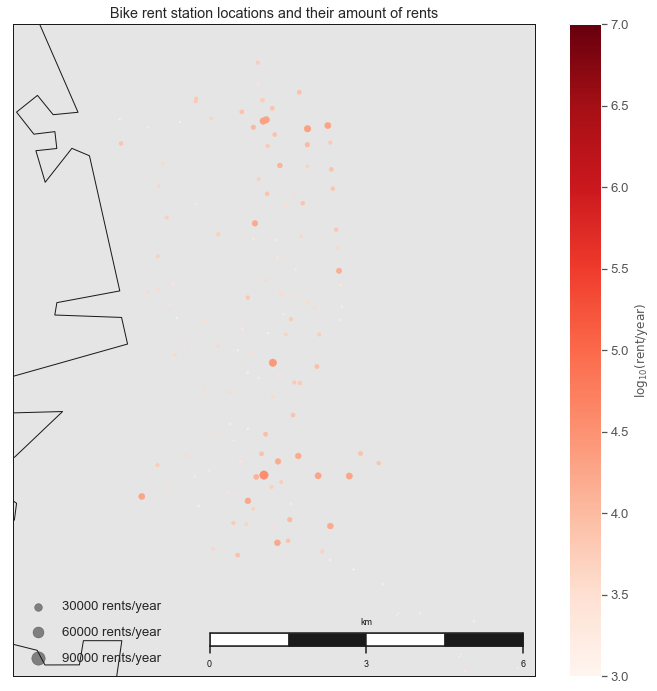

In [41]:
# draw map for first cluster center
center = C[2]

# 1. Draw the map background
fig = plt.figure(figsize=(12, 12))
m = Basemap(projection='tmerc', resolution='h', 
            lat_0=center[0], lon_0=center[1],
            width=0.01E6, height=0.0125E6)
#m.shadedrelief()
m.drawcoastlines()
m.drawcountries(color='gray')
#m.fillcontinents(color="#cc9955", lake_color="aqua")
m.drawmapboundary()
#m.drawrivers()
#m.drawstates(color='gray')

m.drawmapscale(lon=center[1]+0.02, lat=center[0]-0.05, 
               lon0=center[1], lat0=center[0], length=6, barstyle='fancy')

# 2. scatter city data, with color reflecting population
# and size reflecting area
m.scatter(lon, lat, latlon=True,
          c=np.log10(amount), s=amount/500,
          cmap='Reds', alpha=1)
#plt.scatter(lon, lat, 10, marker='o', color='red')

#x, y = m(lon, lat) # transform coordinates
#plt.scatter(x,y,10, marker='o', color='red')


plt.title('Bike rent station locations and their amount of rents');
#plt.show()

# 3. create colorbar and legend
plt.colorbar(label=r'$\log_{10}({\rm rent/year})$')
plt.clim(3, 7)

# make legend with dummy points
for a in [30000, 60000, 90000]:
    plt.scatter([], [], c='k', alpha=0.5, s=a/500,
                label=str(a) + ' rents/year')
plt.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left');

In the above maps of the 3 cities we can see the distributed locations of the rent stations in each city and their different amount of rents/year.

#### New feature: Cluster ID

Add the feature `cluster_id`, that was found with the *nearest-neighbour* algorithm above into the **station dataframe**.

In [42]:
clustered_stations = pd.DataFrame()
clustered_stations['latitude'] = pd.Series(X[:,0])
clustered_stations['longitude'] = pd.Series(X[:,1])
clustered_stations['cluster_id'] = pd.Series(clusters).astype(int)
clustered_stations.shape

(358, 3)

In [43]:
clustered_stations.head()

,latitude,longitude,cluster_id
0,37.784872,-122.400876,1
1,37.804770,-122.403234,1
2,37.770407,-122.391198,1
3,37.336802,-121.894090,0
4,37.329732,-121.901782,0


In [44]:
# new feature
station_clean['cluster_id'] = clustered_stations['cluster_id']
station_clean['cluster_id'].value_counts()

1    160
2    145
0     53
Name: cluster_id, dtype: int64

In [45]:
clustered_stations['cluster_id'] = clustered_stations['cluster_id'].replace({0: 'San_Jose', 1: 'San_Francisco', 2: 'East_Bay'})

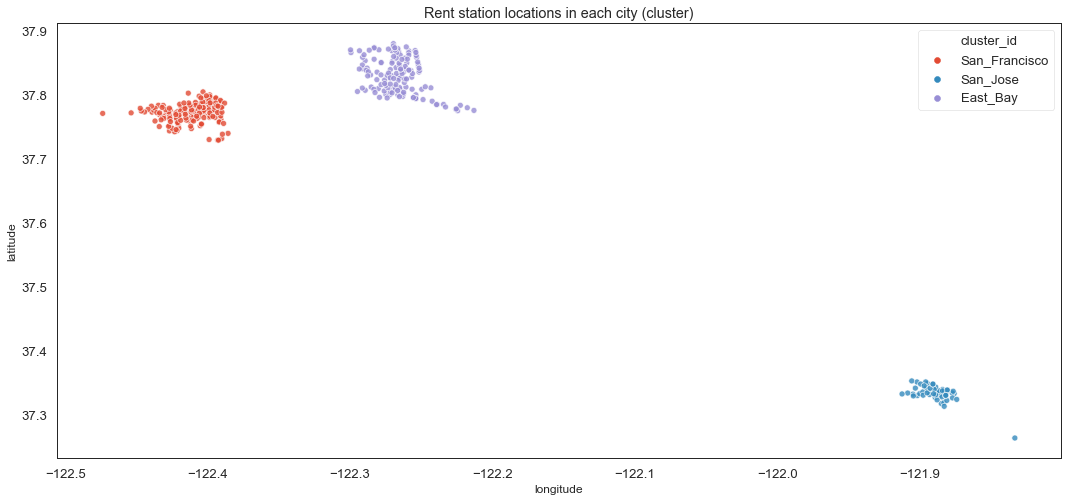

In [46]:
sns.set_style("white")

fig, ax = fig, ax = plt.subplots()
fig.set_size_inches(18, 8)
ax = sns.scatterplot(x="longitude", y="latitude",
                      hue="cluster_id", alpha=.8,
                      data=clustered_stations);
#ax.set_ylim(rush_stations['latitude'].min(), rush_stations['latitude'].max())
ax.set_title("Rent station locations in each city (cluster)");

Now we can see, that the cluster labels are within our station dataframe. Each cluster is colored differently and named by it's city's name.

In [47]:
clustered_stations['cluster_id'].value_counts()

San_Francisco    160
East_Bay         145
San_Jose          53
Name: cluster_id, dtype: int64

In [48]:
list(clustered_stations)

['latitude', 'longitude', 'cluster_id']

In [49]:
clustered_stations['cluster_id'].isnull().sum()

0

#### New feature: cluster id in rent table

Add the feature `cluster_id` into the **rent dataframe**. Therefor a sample of the rent dataframe is used. Otherwise iteration over all rows takes too much computation time (with 1863721 rows). A subset of size 10000 is used.

In [50]:
copy_of_member_and_rent = rent_clean.copy()
copy_of_member_and_rent['member_gender'] = member_clean['member_gender']
copy_of_member_and_rent['age'] = member_clean['age']
copy_of_member_and_rent['user_type'] = member_clean['user_type']

rent_sample = copy_of_member_and_rent.sample(10000)

In [51]:
# bring station id into temp clustered_stations dataframe
clustered_stations['id'] = -1

for i, row in clustered_stations.iterrows():
    # lookup table - look up the cluster id of the given station id and write to rent table
    lat_temp = row['latitude']
    long_temp = row['longitude']
    frame = station_clean.query('latitude == @lat_temp')
    frame = station_clean.query('longitude == @long_temp')
    
    station_id = frame['id'].iloc[0]
    # write to short rent table
    clustered_stations.loc[i, 'id'] = station_id
    

In [52]:
# bring cluster id into rent_clean dataframe
rent_sample['cluster_id'] = -1

for i, row in rent_sample.iterrows():
    # lookup table - look up the cluster id of the given station id and write to rent table
    station_id = row['start_station_id']
    frame = clustered_stations.query('id == @station_id')
    cluster_id = frame['cluster_id'].iloc[0]
    # write to short rent table
    rent_sample.loc[i, 'cluster_id'] = cluster_id
    

In [53]:
rent_sample['start_station_id'].nunique()

317

In [54]:
rent_sample['end_station_id'].nunique()

316

 321 of 358 stations are contained in the dataset. Thus, sample data the stations are still well enough distributed over all 3 cities.

Write amount also into stations dataframe.

In [55]:
(station_clean.index == clustered_stations.index).sum()

358

The ids from clustered_stations and station_clean are not the same. So we need to iterate through both using the station id to copy the cluster_ids to the station_clean dataframe. 

In [56]:
station_clean['cluster_name'] = ''
for i, row in station_clean.iterrows():
    # lookup table - look up the cluster id of the given station id and write to rent table
    station_id = row['id']
    frame = clustered_stations.query('id == @station_id')
    cluster_id = frame['cluster_id'].iloc[0]
    # write to short rent table
    station_clean.loc[i, 'cluster_name'] = cluster_id

In [57]:
station_clean['cluster_name'].isnull().sum()

0

In [58]:
station_clean['cluster_name'].unique()

array(['San_Francisco', 'San_Jose', 'East_Bay'], dtype=object)

In [59]:
station_clean['amount'] = rush_stations['amount']
# and replace cluster ids with names
station_clean['cluster_id'] = station_clean['cluster_name'].replace({'San_Jose': 0, 'San_Francisco': 1, 'East_Bay': 2})

In [60]:
list(station_clean)

['id', 'latitude', 'longitude', 'name', 'cluster_id', 'cluster_name', 'amount']

Now let's have a look into the 3 different cities. Are their stations are all simialar busy or are their more busy stations or more busy cities?

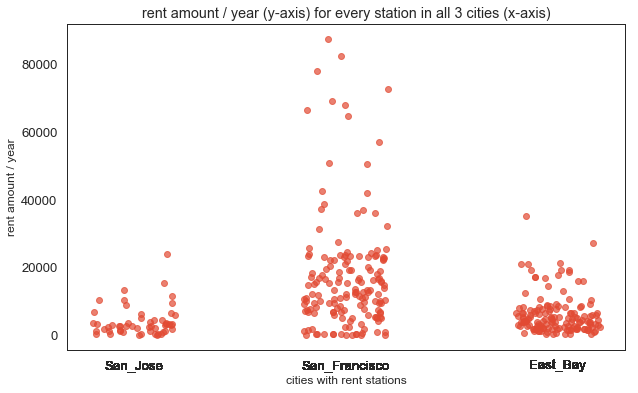

In [61]:
fig, ax = fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
sns.regplot( x = station_clean['cluster_id'], y = station_clean['amount'],
            x_jitter = 0.2, scatter_kws={"alpha":0.7}, fit_reg=False);
ax.set_xlabel('cities with rent stations')
ax.set_ylabel('rent amount / year')
ax.set_xticks(station_clean['cluster_id'])
ax.set_xticklabels(station_clean['cluster_name'])

ax.set_title('rent amount / year (y-axis) for every station in all 3 cities (x-axis)');

In the above plot we can see every station related to a cluster (city) and its rent amount / year (y-axis). We can see, that San Francisco has the most busiest stations. Now we want to create a new feature. A busy-feature, by splitting the y-axis values into 3 categories.

In [62]:
# new feature to distinguish between 3 busy stages
station_clean['busy'] = 0
# assign data two two groups of business (depending on amount)
where_above_upper_threshold = station_clean['amount'] > 60000 
where_underneith_upper_threshold = station_clean['amount'] <= 60000 
where_above_lower_threshold = station_clean['amount'] > 20000  

station_clean.loc[where_above_upper_threshold,'busy'] = 2
station_clean.loc[where_underneith_upper_threshold & where_above_lower_threshold,'busy'] = 1

list(station_clean)

['id',
 'latitude',
 'longitude',
 'name',
 'cluster_id',
 'cluster_name',
 'amount',
 'busy']

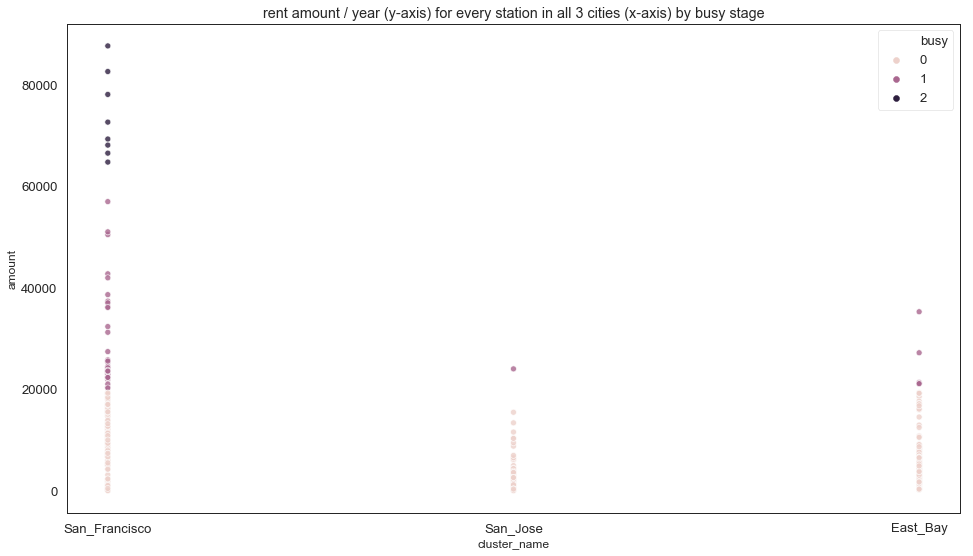

In [63]:
ax = sns.scatterplot(x="cluster_name", y="amount",x_jitter = True,
                      hue="busy", alpha=.8, 
                      data=station_clean)
ax.set_title("rent amount / year (y-axis) for every station in all 3 cities (x-axis) by busy stage");

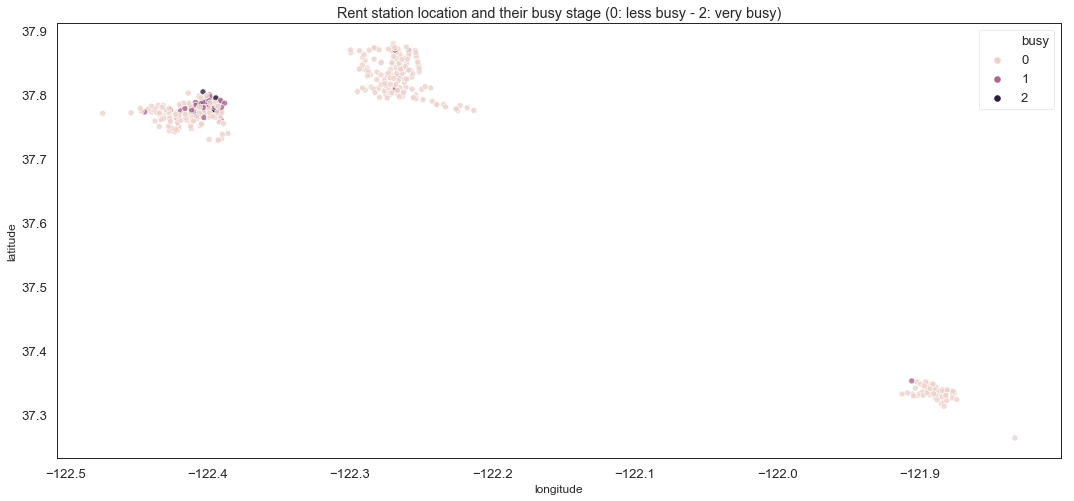

In [64]:
sns.set_style("white")

fig, ax = fig, ax = plt.subplots()
fig.set_size_inches(18, 8)
ax = sns.scatterplot(x="longitude", y="latitude",
                      hue="busy", alpha=.8,
                      data=station_clean);
#ax.set_ylim(rush_stations['latitude'].min(), rush_stations['latitude'].max())
ax.set_title("Rent station location and their busy stage (0: less busy - 2: very busy)");

Now we can see, the new `busy` categories, that are created as new features for further investigations.

Bring the new feature `busy` to the rent dataframe (using only the start rent staion id to combine for simplicity reasons).

In [65]:
# bring cluster id into rent_clean dataframe
rent_sample['busy'] = -1

for i, row in rent_sample.iterrows():
    # lookup table - look up the cluster id of the given station id and write to rent table
    station_id = row['start_station_id']
    frame = station_clean.query('id == @station_id')
    busy_value = frame['busy'].iloc[0]
    # write to short rent table
    rent_sample.loc[i, 'busy'] = busy_value

### 4.4 Member differences in different cities

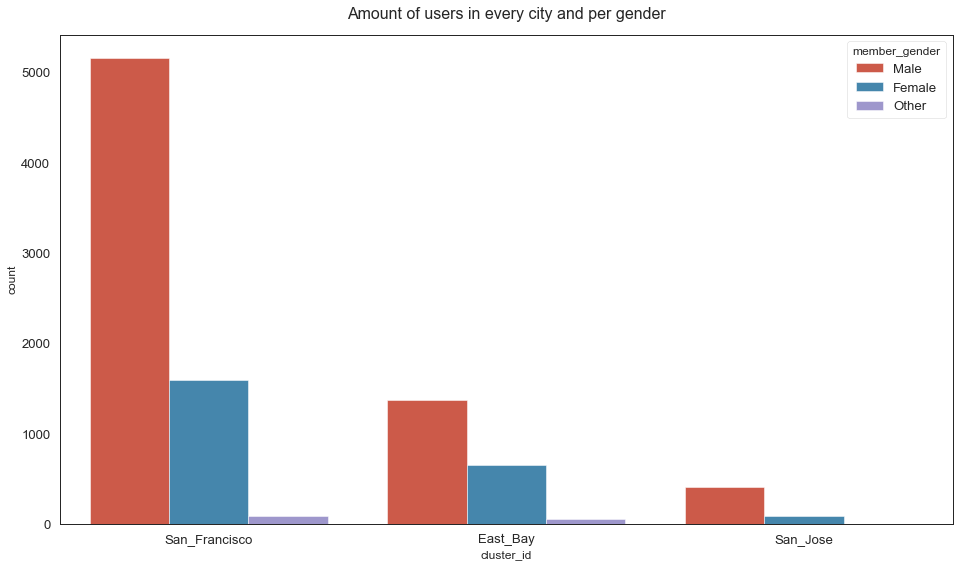

In [68]:
ax1 = sns.countplot(data = rent_sample, x = 'cluster_id', hue = 'member_gender');
ax1.set_title("Amount of users in every city and per gender", y=1.02,fontsize=16);

In [ ]:
rent_sample.groupby('cluster_id')['member_gender'].value_counts()

In the above plot we can see the count of users (every rent counts as one individual user) per city (x-axis) and per gender (colors). In San Francisco only almmost 1/4 of the users are female and more than 3/4 are male. In East Bay almost 1/3 of the users are female and 2/3 are male. In San Jose a little bit more than 1/4 are female and less than 3/4 are male users.

In [ ]:
# left plot: violin plot
ax1 = sns.violinplot(data = rent_sample, x = 'member_gender', y = 'age', color = base_color)
ax1.set_title("Average age of users per gender", y=1.02,fontsize=16);

In [ ]:
rent_sample.groupby('member_gender')['age'].mean()

In the above plot we can see, that the average age of female users is 33.7 and of male users is 35.3 years old.

In [ ]:
rent_sample.groupby('user_type')['age'].mean()

In [ ]:
# left plot: violin plot
ax1 = sns.violinplot(data = rent_sample, x = 'user_type', y = 'age', color = base_color)
ax1.set_title("Average age of users per user type", y=1.02,fontsize=16);

In the above plot we can see, that the age of subscribers are more distributed than of customers (Maximum age is over 90 for subscriber and about 75 for customers). Also the average is younger for customer users with about 32 vs. 35 years for subsriber users.

In [ ]:
# left plot: violin plot
#plt.subplot(1, 2, 1)
ax1 = sns.violinplot(data = rent_sample, x = 'cluster_id', y = 'age', color = base_color)
ax1.set_title("Average age of users in every city", y=1.02,fontsize=16);

In [ ]:
rent_sample.groupby('cluster_id')['age'].mean()

More interesting is the average age of the different cities. In San Francisco the user age's average is over 35, in East Bay about 34 and in San Jose the average age is 30 and less distributed over all ages.

In [ ]:
bins = np.arange(rent_sample['age'].min(), rent_sample['age'].max()+1, 1);

g = sns.FacetGrid(data = rent_sample, col = 'cluster_id', row = 'member_gender', height = 4,
                margin_titles = True);
g.map(plt.hist, 'age', bins = bins);
g.fig.suptitle("Distribution of user's age for each city (column) and each gender (row)", y=1.02,fontsize=16);

In this plot we can see the distribution of user's age for every gender (rows) in every city (columns). Beside that we can see that San Francisco has the most users and San Jose the fewest.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> The insights showed, that there are 3 cities, where the rent service is provided and where rent stations are located.

> Also, we could confirm that there are more busy rent stations and less busy rent stations. We categorized 3 different business levels to make further investigations on that. And plotted the locations with the amount of rents (businest factor). The busiest stations are located in San Francisco.

> With a clustering of the rent station locations, we could provide the city label for the station and rent data. With that label, we could investigate a analysis on user's age and gender in the different cities.

### Were there any interesting or surprising interactions between features?

> In San Francisco and San Jose only 1/5 of the users are female. Whereas in East Bay about 1/3 are female. So most users are male in every city.

> The average age of the users in San Jose is the lowest with 30 years. Whereas in East Bay and San Francisco the users are in average about 34 and 45 years old.

> The most users are allocated in San Francisco.